# Wine quality analysis - Machine Learning - PART 3

Datasource: https://archive.ics.uci.edu/ml/datasets/wine+quality

## Columns description


Column Position | Atrribute Name | Definition 
 --- | --- | --- 
1 | fixed acidity | most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2 | volatile acidity | the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3 | citric acid | found in small quantities, citric acid can add 'freshness' and flavor to wines
4 | residual sugar | the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5 | chlorides | the amount of salt in the wine
6 | free sulfur dioxidet | he free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7 | total sulfur dioxide | amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8 | density | the density of water is close to that of water depending on the percent alcohol and sugar content
9 | pH | describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10 | sulphates | a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
11 | alcohol | the percent alcohol content of the wine
12 | quality | output variable (based on sensory data, score between 0 and 10)
13 | good | binary evaluation 1 - good , 0 - bad
14 | color | wine type red or white

# Project Plan 

Import libraries <br/>
Data preparation for machine learning<br/>
Data preparation for machine learning - Red only<br/>
Data preparation for machine learning - White only<br/>
Random Forest Regression<br/>
All wine regression model<br/>
Red only regression model<br/>
White only regression model<br/>
Regression results Analysis<br/>
Random Forest Binary Classification<br/>
Random Forest Classification - All wine<br/>
Random Forest Classification - Red Wine only<br/>
Random Forest Classification - White Wine only<br/>
Random Forest, Encode Wine type and include in the model<br/>
Random Forest Classification Results analysis <br/>
Mutli-calss classification<br/>
Mutli-calss classification - All wine encoded<br/>
Mutli-calss classification - Only red wine<br/>
Mutli-calss classification - Only white wine<br/>
Mutli-calss classification Results Analysis<br/>
Gradient-boosted tree classifier -binary<br/>
Gradient-boosted tree classifier - All wine<br/>
Gradient-boosted tree classifier - Red wine only<br/>
Gradient-boosted tree classifier - White wine only<br/>
Clustering<br/>
PCA for Cluster visualisation<br/>
Clustering Analysis<br/>
Multilayer perceptron classifier<br/>
Multilayer perceptron classifier - All wine<br/>
Multilayer perceptron classifier - Red wine only<br/>
Multilayer perceptron classifier - White wine only<br/>
Multilayer perceptron classifier - Results analysis<br/>


# Import libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import numpy as np

#import stats libraries 
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SparkSession

In [2]:
# May take a little while on a local computer
spark = SparkSession.builder.appName("winequality").getOrCreate()

In [3]:
df = spark.read.csv("winequality.csv",header=True,inferSchema=True)

In [4]:
#df.show(n=2, truncate=False, vertical=True)
df.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


In [5]:
#Create DF for red and white wine
df_red = df.filter(df.color =='red')
df_white = df.filter(df.color =='white')

In [6]:
#create lists of categorical and numberical columns

cat = [item[0] for item in df.dtypes if item[1].startswith('string') ]
num = [item for item in df.columns if item not in cat]
print(cat)
print(num)

['color']
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'good']


# Data preparation for machine learning

In [7]:
#Import libraries
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

In [8]:
#create input vector
features_column = num[0:-2]

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep = assembler.transform(df)
#finalPrep.show(n=1, truncate=False, vertical=True)
finalPrep.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red,"[7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.996..."
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red,"[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.99..."
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red,"[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.9..."
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."


In [9]:
#split in training and testing datasets
training, test = finalPrep.randomSplit([0.7, 0.3])
# Going to cache the data  
training.cache()
test.cache()
print(training.count())
print(test.count())

4560
1937


### Data preparation for machine learning - Red only

In [10]:
#create input vector
features_column = num[0:-2]

assembler_red = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_red = assembler_red.transform(df_red)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_red.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red,"[7.8, 0.88, 0.0, 2.6, 0.098, 25.0, 67.0, 0.996..."
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red,"[7.8, 0.76, 0.04, 2.3, 0.092, 15.0, 54.0, 0.99..."
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red,"[11.2, 0.28, 0.56, 1.9, 0.075, 17.0, 60.0, 0.9..."
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red,"[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978..."


In [11]:
#split in training and testing datasets
training_red, test_red = finalPrep_red.randomSplit([0.7, 0.3])
# Going to cache the data  
training_red.cache()
test_red.cache()
print(training_red.count())
print(test_red.count())

1076
523


### Data preparation for machine learning - White only

In [12]:
#create input vector
features_column = num[0:-2]

assembler_white = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_white = assembler_red.transform(df_white)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_white.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,white,"[7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 1...."
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,white,"[6.3, 0.3, 0.34, 1.6, 0.049, 14.0, 132.0, 0.99..."
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,white,"[8.1, 0.28, 0.4, 6.9, 0.05, 30.0, 97.0, 0.9951..."
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,white,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,white,"[7.2, 0.23, 0.32, 8.5, 0.058, 47.0, 186.0, 0.9..."


In [13]:
#split in training and testing datasets
training_white, test_white = finalPrep_white.randomSplit([0.7, 0.3])
# Going to cache the data  
training_white.cache()
test_white.cache()
print(training_white.count())
print(test_white.count())

3490
1408


# Random Forest Regression

Tested the follwoing parameters: 


paramGrid = (ParamGridBuilder() <br/>
  .addGrid(rfModel.maxDepth, [3, 5, 7,10, 15, 20, 30])<br/>
  .addGrid(rfModel.numTrees, [5, 10, 20,60,100, 200])<br/>
  .addGrid(rfModel.featureSubsetStrategy, ['auto','sqrt', 'log2'])<br/>
  .addGrid(rfModel.maxBins, [24, 32, 48])<br/>
  .build())</br>
  
To increase the speed of search i only enter the best parameters

In [14]:
def RFRegressor(training, test):
    rfModel = (RandomForestRegressor()
      .setLabelCol("quality")
      .setFeaturesCol("features"))
    
    paramGrid = (ParamGridBuilder()
      .addGrid(rfModel.maxDepth, [5, 10])
      .addGrid(rfModel.numTrees, [20, 60])
      .build())

    stages = [rfModel]
    pipeline = Pipeline().setStages(stages)
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(RegressionEvaluator().setLabelCol("quality")))
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(quality)) as quality")
    display(test_predict.show(3))
    
    return test_predict

### All wine regression model

In [15]:
def AccuracyEvaluation(test_predict):
    acc = test_predict.selectExpr("prediction", "quality",
                        """
                        CASE prediction = quality
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
    display(acc.selectExpr("sum(equal)/sum(1)").show())


In [16]:
test_predict = RFRegressor(training, test)

The Best Parameters:
--------------------
RandomForestRegressionModel: uid=RandomForestRegressor_1a17950714bb, numTrees=60, numFeatures=11
+----------+-------+
|prediction|quality|
+----------+-------+
|       7.0|    8.0|
|       6.0|    3.0|
|       6.0|    5.0|
+----------+-------+
only showing top 3 rows



None

In [17]:
AccuracyEvaluation(test_predict)

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.6081569437274136|
+---------------------+



None

### Red only regrerssion model

In [18]:
test_predict_red = RFRegressor(training_red, test_red)
AccuracyEvaluation(test_predict_red)

The Best Parameters:
--------------------
RandomForestRegressionModel: uid=RandomForestRegressor_efe117aec0be, numTrees=60, numFeatures=11
+----------+-------+
|prediction|quality|
+----------+-------+
|       6.0|    6.0|
|       7.0|    7.0|
|       6.0|    6.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.6806883365200764|
+---------------------+



None

### White only regrerssion model

In [19]:
test_predict_white = RFRegressor(training_white, test_white)
AccuracyEvaluation(test_predict_white)

The Best Parameters:
--------------------
RandomForestRegressionModel: uid=RandomForestRegressor_d2cd4f9a7098, numTrees=60, numFeatures=11
+----------+-------+
|prediction|quality|
+----------+-------+
|       6.0|    6.0|
|       7.0|    6.0|
|       7.0|    7.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.6029829545454546|
+---------------------+



None

## Regression results Analysis 

It was an interesting exercise to apply regression method to a classification problem. The reason it could be done because quality is ranging from 1 to 9. 
In case of all wine and red wine the prediction accuracy at 0.6

Next we will look at binary classification and multi-class classification to improve the results. 

# Random Forest Binary Classification 

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.evaluation import BinaryClassificationEvaluator
import sklearn 
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
def RFClassifer(training, test):
    rfModel = (RandomForestClassifier()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(rfModel.maxDepth, [5, 10])
      .addGrid(rfModel.numTrees, [20, 60])
      .build())

    stages = [rfModel]
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

In [22]:
def ConfMatrix(test_predict):
        #collect prediction and true value
    y_true = test_predict.select(['good']).collect()
    y_pred = test_predict.select(['prediction']).collect()

    #classification report
    print(classification_report(y_true, y_pred))
    
    #confusion matrix 

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [23]:
def Evaluation(test_predict):
    acc = test_predict.selectExpr("prediction", "good",
                        """
                        CASE prediction = good
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
        
    print(acc.selectExpr("sum(equal)/sum(1)").show())

    # Another way to evaluate error
    evaluator = MulticlassClassificationEvaluator(labelCol="good", predictionCol="prediction", metricName="accuracy")
    
    accuracy = evaluator.evaluate(test_predict)
    print("Test Error = %g" % (1.0 - accuracy))
    
    ConfMatrix(test_predict)

### Random Forest Classification - All wine

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_6c1dcf9f738d, numTrees=60, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       0.0| 0.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8626742385131647|
+---------------------+

None
Test Error = 0.137326
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      1556
         1.0       0.75      0.45      0.57       381

    accuracy                           0.86      1937
   macro avg       0.81      0.71      0.74      1937
weighted avg       0.85      0.86      0.85      1937



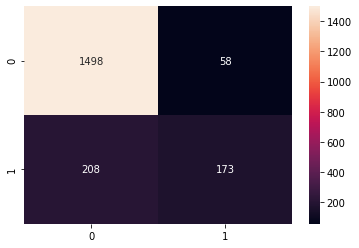

In [26]:
test_predict = RFClassifer(training, test)
Evaluation(test_predict)

### Random Forest Classification - Red Wine only

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_570e5b249d15, numTrees=60, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       1.0| 1.0|
|       1.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8852772466539197|
+---------------------+

None
Test Error = 0.114723
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.93       448
         1.0       0.65      0.43      0.52        75

    accuracy                           0.89       523
   macro avg       0.78      0.69      0.73       523
weighted avg       0.87      0.89      0.87       523



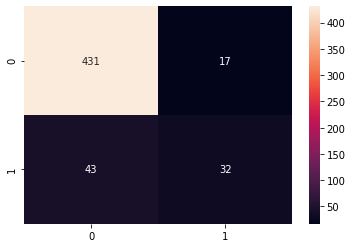

In [27]:
test_predict = RFClassifer(training_red, test_red)
Evaluation(test_predict)

### Random Forest Classification - White Wine only

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_b4616fb4bc10, numTrees=60, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       1.0| 0.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8536931818181818|
+---------------------+

None
Test Error = 0.146307
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      1083
         1.0       0.78      0.50      0.61       325

    accuracy                           0.85      1408
   macro avg       0.83      0.73      0.76      1408
weighted avg       0.85      0.85      0.84      1408



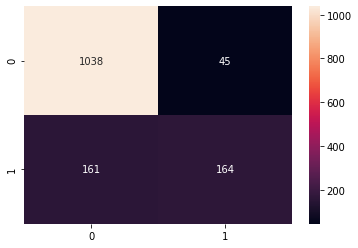

In [28]:
test_predict = RFClassifer(training_white, test_white)
Evaluation(test_predict)

# Random Forest, Encode Wine type and include in the model

In [29]:
cat

['color']

In [30]:
#convert cat data into INT

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in cat:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df)
#transform the dataframe
df_enc= pipelineModel.transform(df)

In [31]:
df_enc.show(n=2, truncate=False, vertical=True)

-RECORD 0----------------------
 fixed acidity        | 7.4    
 volatile acidity     | 0.7    
 citric acid          | 0.0    
 residual sugar       | 1.9    
 chlorides            | 0.076  
 free sulfur dioxide  | 11.0   
 total sulfur dioxide | 34.0   
 density              | 0.9978 
 pH                   | 3.51   
 sulphates            | 0.56   
 alcohol              | 9.4    
 quality              | 5      
 good                 | 0      
 color                | red    
 colorIndex           | 1.0    
-RECORD 1----------------------
 fixed acidity        | 7.8    
 volatile acidity     | 0.88   
 citric acid          | 0.0    
 residual sugar       | 2.6    
 chlorides            | 0.098  
 free sulfur dioxide  | 25.0   
 total sulfur dioxide | 67.0   
 density              | 0.9968 
 pH                   | 3.2    
 sulphates            | 0.68   
 alcohol              | 9.8    
 quality              | 5      
 good                 | 0      
 color                | red    
 colorIn

In [32]:
num_enc = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'colorIndex']
num_enc

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'colorIndex']

In [33]:
#create input vector
features_column = num_enc

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep = assembler.transform(df_enc)
finalPrep.show(n=1, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------
 fixed acidity        | 7.4                                                        
 volatile acidity     | 0.7                                                        
 citric acid          | 0.0                                                        
 residual sugar       | 1.9                                                        
 chlorides            | 0.076                                                      
 free sulfur dioxide  | 11.0                                                       
 total sulfur dioxide | 34.0                                                       
 density              | 0.9978                                                     
 pH                   | 3.51                                                       
 sulphates            | 0.56                                                       
 alcohol              | 9.4                                                 

In [34]:
#split in training and testing datasets
training_enc, test_enc = finalPrep.randomSplit([0.7, 0.3])
# Going to cache the data  
training_enc.cache()
test_enc.cache()
print(training_enc.count())
print(test_enc.count())

4569
1928


The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_72f2654a01ba, numTrees=60, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       1.0| 0.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8563278008298755|
+---------------------+

None
Test Error = 0.143672
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91      1550
         1.0       0.72      0.44      0.54       378

    accuracy                           0.86      1928
   macro avg       0.80      0.70      0.73      1928
weighted avg       0.84      0.86      0.84      1928



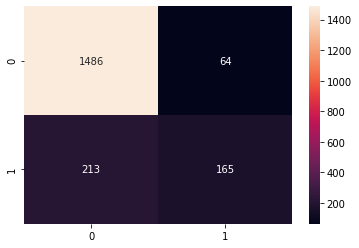

In [35]:
test_predict = RFClassifer(training_enc, test_enc)
Evaluation(test_predict)

# Random Forest Classification Results analysis 


Encoding red or white wine and including data in the model does not improve model. Separating model into two models for red and white wine increases accuracy of the model. 

# Mutli-calss classification

In [36]:
def MC_RFClassifer(training, test):
    rfModel = (RandomForestClassifier()
      .setLabelCol("quality")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(rfModel.maxDepth, [5, 10])
      .addGrid(rfModel.numTrees, [20, 60])
      .build())

    stages = [rfModel]
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("quality")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(quality)) as quality")
    display(test_predict.show(3))
    
    return test_predict

In [37]:
def MC_ConfMatrix(test_predict):
        #collect prediction and true value
    y_true = test_predict.select(['quality']).collect()
    y_pred = test_predict.select(['prediction']).collect()

    #classification report
    print(classification_report(y_true, y_pred))
    
    #confusion matrix 

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [38]:
def MC_Evaluation(test_predict):
    acc = test_predict.selectExpr("prediction", "quality",
                        """
                        CASE prediction = quality
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
        
    print(acc.selectExpr("sum(equal)/sum(1)").show())

    # Another way to evaluate error
    evaluator = MulticlassClassificationEvaluator(labelCol="quality", predictionCol="prediction", metricName="accuracy")
    
    accuracy = evaluator.evaluate(test_predict)
    print("Test Error = %g" % (1.0 - accuracy))
    
    MC_ConfMatrix(test_predict)

### All wine encoded 

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_5ca5258ccac2, numTrees=20, numClasses=10, numFeatures=12
+----------+-------+
|prediction|quality|
+----------+-------+
|       5.0|    3.0|
|       7.0|    6.0|
|       6.0|    5.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.5425311203319502|
+---------------------+

None
Test Error = 0.457469
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         9
         4.0       0.00      0.00      0.00        69
         5.0       0.62      0.59      0.61       655
         6.0       0.50      0.74      0.60       817
         7.0       0.55      0.18      0.27       323
         8.0       0.00      0.00      0.00        54
         9.0       0.00      0.00      0.00         1

    accuracy                           0.54      1928
   macro avg       0.24      0.21      0.21      1928
weighted avg       0.52      0.54      0.50      1928



/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


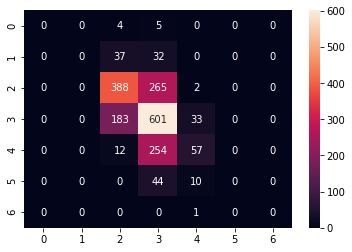

In [39]:
test_predict = MC_RFClassifer(training_enc, test_enc)
MC_Evaluation(test_predict)

### Mutli-calss classification  - Only red wine

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_0f2feba287b7, numTrees=20, numClasses=9, numFeatures=11
+----------+-------+
|prediction|quality|
+----------+-------+
|       7.0|    6.0|
|       6.0|    7.0|
|       6.0|    6.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.6252390057361377|
+---------------------+

None
Test Error = 0.374761
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00        20
         5.0       0.71      0.76      0.73       222
         6.0       0.55      0.68      0.61       205
         7.0       0.62      0.25      0.36        71
         8.0       0.00      0.00      0.00         4

    accuracy                           0.63       523
   macro avg       0.31      0.28      0.28       523
weighted avg       0.60      0.63      0.60       523



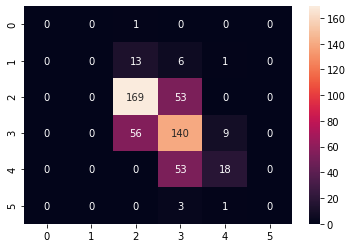

In [40]:
test_predict = MC_RFClassifer(training_red, test_red)
MC_Evaluation(test_predict)

### Mutli-calss classification - Only white wine

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_51925a185f8a, numTrees=20, numClasses=10, numFeatures=11
+----------+-------+
|prediction|quality|
+----------+-------+
|       6.0|    6.0|
|       7.0|    6.0|
|       6.0|    7.0|
+----------+-------+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|            0.5390625|
+---------------------+

None
Test Error = 0.460938
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         5
         4.0       0.00      0.00      0.00        49
         5.0       0.60      0.61      0.60       411
         6.0       0.51      0.76      0.61       618
         7.0       0.55      0.15      0.24       273
         8.0       0.00      0.00      0.00        51
         9.0       0.00      0.00      0.00         1

    accuracy                           0.54      1408
   macro avg       0.24      0.22      0.21      1408
weighted avg       0.51      0.54      0.49      1408



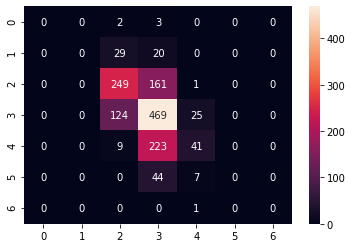

In [41]:
test_predict = MC_RFClassifer(training_white, test_white)
MC_Evaluation(test_predict)

## Mutli-calss classification Results Analysis:
Multi-class classification does not produce very accurate results compared to binary classification.
However, it produces better results than regression model

# Gradient-boosted tree classifier -binrary

In [42]:
from pyspark.ml.classification import GBTClassifier

In [43]:
def BGTCClassifer(training, test):
    model = (GBTClassifier()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    
    paramGrid = (ParamGridBuilder()
      .addGrid(model.maxDepth, [7, 15])
      .addGrid(model.maxIter, [25])
      .build())

    stages = [model]
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

### Gradient-boosted tree classifier - All wine 

In [44]:
test_predict = BGTCClassifer(training_enc, test_enc)

The Best Parameters:
--------------------
GBTClassificationModel: uid = GBTClassifier_b9a7d09a9bd6, numTrees=25, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       1.0| 0.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8469917012448133|
+---------------------+

None
Test Error = 0.153008
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91      1550
         1.0       0.63      0.54      0.58       378

    accuracy                           0.85      1928
   macro avg       0.76      0.73      0.74      1928
weighted avg       0.84      0.85      0.84      1928



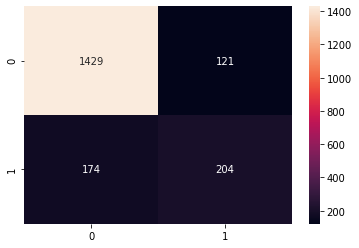

In [45]:
Evaluation(test_predict)

### Gradient-boosted tree classifier - Red wine only

The Best Parameters:
--------------------
GBTClassificationModel: uid = GBTClassifier_93fca5a2a107, numTrees=25, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       0.0| 0.0|
|       1.0| 1.0|
|       0.0| 0.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8795411089866156|
+---------------------+

None
Test Error = 0.120459
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       448
         1.0       0.60      0.49      0.54        75

    accuracy                           0.88       523
   macro avg       0.76      0.72      0.74       523
weighted avg       0.87      0.88      0.87       523



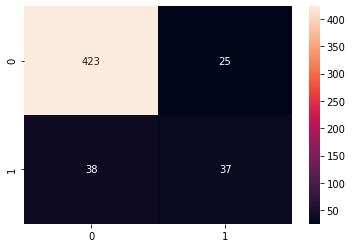

In [46]:
test_predict = BGTCClassifer(training_red, test_red)
Evaluation(test_predict)

### Gradient-boosted tree classifier - White wine only

The Best Parameters:
--------------------
GBTClassificationModel: uid = GBTClassifier_6721c0680b73, numTrees=25, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 0.0|
|       1.0| 0.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8366477272727273|
+---------------------+

None
Test Error = 0.163352
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1083
         1.0       0.68      0.56      0.61       325

    accuracy                           0.84      1408
   macro avg       0.78      0.74      0.76      1408
weighted avg       0.83      0.84      0.83      1408



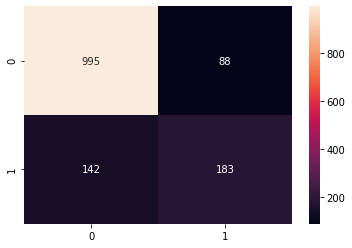

In [47]:
test_predict = BGTCClassifer(training_white, test_white)
Evaluation(test_predict)

# Clustering

In [47]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [48]:
num_clust = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',]

In [49]:
#create input vector
features_column = num_clust

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

dataset = assembler.transform(df)
dataset.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------
 fixed acidity        | 7.4                                                    
 volatile acidity     | 0.7                                                    
 citric acid          | 0.0                                                    
 residual sugar       | 1.9                                                    
 chlorides            | 0.076                                                  
 free sulfur dioxide  | 11.0                                                   
 total sulfur dioxide | 34.0                                                   
 density              | 0.9978                                                 
 pH                   | 3.51                                                   
 sulphates            | 0.56                                                   
 alcohol              | 9.4                                                    
 quality              | 5               

In [50]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dataset)

In [51]:
predictions = model.transform(dataset)

In [52]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6899553418429238
Cluster Centers: 
[6.90383157e+00 2.87090441e-01 3.39704847e-01 7.24164636e+00
 4.85754129e-02 3.97382887e+01 1.55643786e+02 9.94787092e-01
 3.19103710e+00 4.99834823e-01 1.02609387e+01]
[ 7.62553495  0.40891049  0.29088088  3.07464337  0.06585699 18.39140514
 63.19543509  0.9945775   3.2546719   0.57266762 10.79585711]


In [53]:
predictions.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------
 fixed acidity        | 7.4                                                    
 volatile acidity     | 0.7                                                    
 citric acid          | 0.0                                                    
 residual sugar       | 1.9                                                    
 chlorides            | 0.076                                                  
 free sulfur dioxide  | 11.0                                                   
 total sulfur dioxide | 34.0                                                   
 density              | 0.9978                                                 
 pH                   | 3.51                                                   
 sulphates            | 0.56                                                   
 alcohol              | 9.4                                                    
 quality              | 5               

In [54]:
for row in predictions.head(1):
    print(row)
    print('\n')

Row(fixed acidity=7.4, volatile acidity=0.7, citric acid=0.0, residual sugar=1.9, chlorides=0.076, free sulfur dioxide=11.0, total sulfur dioxide=34.0, density=0.9978, pH=3.51, sulphates=0.56, alcohol=9.4, quality=5, good=0, color='red', features=DenseVector([7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]), prediction=1)




In [55]:
print(predictions.groupby("prediction").count().show())

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 2804|
|         0| 3693|
+----------+-----+

None


In [56]:
print(predictions.groupby("good").count().show())

+----+-----+
|good|count|
+----+-----+
|   1| 1277|
|   0| 5220|
+----+-----+

None


In [57]:
#only good for group of 2

In [58]:
acc_clust = predictions.selectExpr("prediction", "good",
                        """
                        CASE prediction = good
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
display(acc_clust.selectExpr("sum(equal)/sum(1)").show())

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.5457903647837463|
+---------------------+



None

In [59]:
#collect prediction and true value
y_true = df.select(['good']).collect()
y_pred = predictions.select(['prediction']).collect()

In [60]:
#classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.57      0.67      5220
           1       0.20      0.44      0.28      1277

    accuracy                           0.55      6497
   macro avg       0.50      0.51      0.47      6497
weighted avg       0.69      0.55      0.59      6497



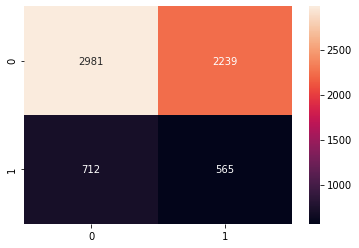

In [61]:
#confusion matrix 

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


In [62]:
df.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


# PCA for Cluster visualisation

In [63]:
from pyspark.ml.feature import PCA
#from pyspark.ml.linalg import Vectors

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(dataset)

result = model.transform(dataset).select("pcaFeatures")
result.show(n=3, truncate=False, vertical=True)

-RECORD 0---------------------------------------------
 pcaFeatures | [35.55730853561848,2.8557329251644883] 
-RECORD 1---------------------------------------------
 pcaFeatures | [70.88903047039945,8.848169692542028]  
-RECORD 2---------------------------------------------
 pcaFeatures | [55.933882405273444,2.124434149984114] 
only showing top 3 rows



In [64]:
pca_plt = pd.DataFrame()
for row in result.rdd.collect():
    #print(row[0][0],row[0][1])
    pca_plt = pca_plt.append({'x' : row[0][0] , 'y' : row[0][1]} , ignore_index=True)

In [65]:
y_pred_pd = pd.DataFrame()
for row in y_pred:
    y_pred_pd = y_pred_pd.append({'clust':row[0]}, ignore_index=True)


In [66]:
pca_plt_clust = pd.concat([pca_plt, y_pred_pd], axis=1)

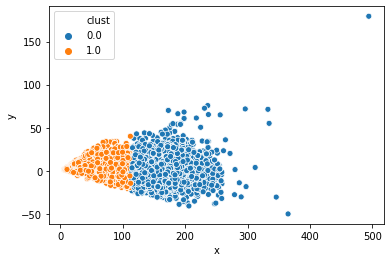

In [67]:
sns.scatterplot(x="x", y="y", hue='clust', data=pca_plt_clust)

In [68]:
#Visualisation of Wine Quality

In [69]:
qlty = df.select('good').collect()

In [70]:
wine_qlty = pd.DataFrame()
for row in qlty:
    wine_qlty = wine_qlty.append({'good':row[0]}, ignore_index=True)

In [71]:
pca_plt_clust = pd.concat([pca_plt_clust, wine_qlty], axis=1)
pca_plt_clust

,x,y,clust,good
0,35.557309,2.855733,1.0,0.0
1,70.889030,8.848170,1.0,0.0
2,55.933882,2.124434,1.0,0.0
3,62.187191,2.655752,1.0,0.0
4,35.557309,2.855733,1.0,0.0
...,...,...,...,...
6492,94.926945,2.084641,1.0,0.0
6493,176.685818,16.707601,0.0,0.0
6494,114.772316,3.509418,0.0,0.0
6495,111.479926,-5.972431,1.0,1.0


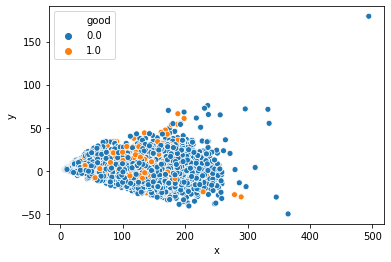

In [72]:
sns.scatterplot(x="x", y="y", hue='good', data=pca_plt_clust)

# Clustering Analysis
From the results above it is clear that k-mean clustering does not provide better model than other Random Forest. 

# Multilayer perceptron classifier

In [18]:
from pyspark.ml.classification import MultilayerPerceptronClassifier


from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import sklearn 
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
def MLPClassifier(training,test, num_enc):
    # specify layers for the neural network:
    # input layer of size 4 (features), two intermediate of size 5 and 4
    # and output of size 3 (classes)
    features_number = len(num_enc)
    layers = [features_number, features_number+1, features_number, 2]
    
    

    # create the trainer and set its parameters
    trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, labelCol='good',featuresCol='features')

    # train the model
    model = trainer.fit(training)

    # compute accuracy on the test set
    result = model.transform(test)
    
    test_predict = result.select("prediction", "good")
    
    return test_predict

    

### Multilayer perceptron classifier - All wine

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8179979777553084|
+---------------------+

None
Test Error = 0.182002
              precision    recall  f1-score   support

           0       0.85      0.95      0.89      1602
           1       0.54      0.27      0.36       376

    accuracy                           0.82      1978
   macro avg       0.69      0.61      0.63      1978
weighted avg       0.79      0.82      0.79      1978



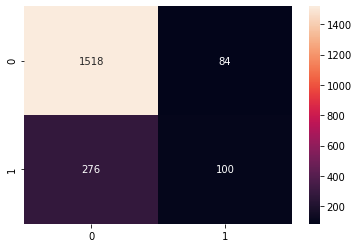

In [31]:
test_predict = MLPClassifier(training_enc,test_enc, num_enc)
Evaluation(test_predict)

### Multilayer perceptron classifier - red wine only

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7896928682977615|
+---------------------+

None
Test Error = 0.210307
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1501
           1       0.62      0.10      0.17       420

    accuracy                           0.79      1921
   macro avg       0.71      0.54      0.52      1921
weighted avg       0.76      0.79      0.72      1921



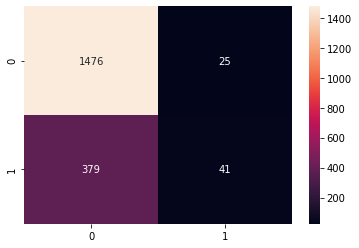

In [34]:
test_predict = MLPClassifier(training_red,test_red, features_column)
Evaluation(test_predict)

### Multilayer perceptron classifier - white wine only

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7868190988567586|
+---------------------+

None
Test Error = 0.213181
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1173
           1       0.48      0.15      0.23       314

    accuracy                           0.79      1487
   macro avg       0.65      0.55      0.55      1487
weighted avg       0.74      0.79      0.74      1487



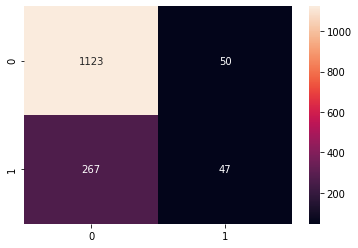

In [23]:
test_predict = MLPClassifier(training_white,test_white, features_column)
Evaluation(test_predict)

## Multilayer perceptron classifier results analysis 

This model does not produce better results than Random Forest. 
we have tried adjusting layers, adding more and changing the size of hidden layers, yet the results are not improving
